In [1]:
import sys
import math
import random; random.seed(90)

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, deque

import gym

In [2]:
import check_test
from utils import plot_values
from cliffwalking import CliffWalkingEnv

In [3]:
import warnings 
warnings.filterwarnings('ignore')

## Explore The Environment

In [4]:
env = CliffWalkingEnv()

In [5]:
print('Environment Display:')
env.render()

Environment Display:
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [6]:
# print the state space and action space
print('State space:', env.observation_space)
print('Action space:', env.action_space)

State space: Discrete(48)
Action space: Discrete(4)


In [7]:
# print the total number of states and actions
print('Total number of states', env.nS)
print('Total number of actions', env.nA)

Total number of states 48
Total number of actions 4


## Show Optimal-State Value Function

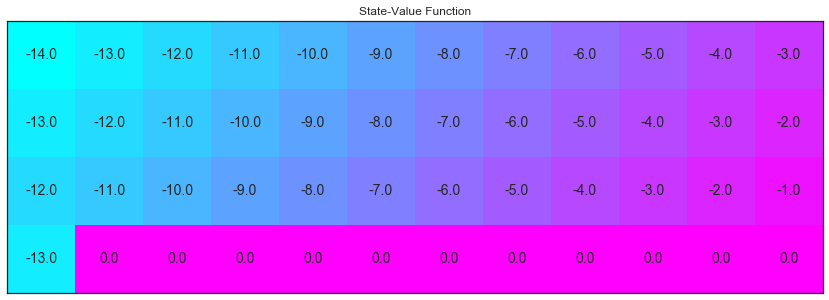

In [8]:
# define the optimal state-value function as a ground truth
V_opt = np.zeros((4,12))
V_opt[0][0:13] = -np.arange(3, 15)[::-1]
V_opt[1][0:13] = -np.arange(3, 15)[::-1] + 1
V_opt[2][0:13] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt, name='State-Value')

## Part 1: TD Control: Sarsa

In [9]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    """Returns updated Q-value for the most recent experience."""
    current_value = Q[state][action] # estimate in Q-table for current state-action pair
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0 # get value of state-action at next time step
    
    TD_target = reward + (gamma * Qsa_next) # construct TD target
    TD_error = TD_target - current_value # construct TD error
    new_value = current_value + (alpha * (TD_error)) # apply update rule
    return new_value

In [10]:
def get_epsilon_greedy(Q, state, nA, epsilon):
    """Selects epsilon-greedy action for supplied state."""
    if random.random() > epsilon: # select greedy action with probability epsilon
        return np.argmax(Q[state])
    else:
        return random.choice(np.arange(env.action_space.n))

In [11]:
def td_control(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    
    nA = env.action_space.n # number of actions
    Q = defaultdict(lambda: np.zeros(nA)) # initialize empty dictionary of arrays
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every) # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes) # average scores over every plot_every episodes
    
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        score = 0 # initialize score
        state = env.reset() # start episode
        
        epsilon = 1.0 / i_episode # set value of epsilon
        action = get_epsilon_greedy(Q, state, nA, epsilon) # epsilon-greedy action selection
        
        while True:
            next_state, reward, done, info = env.step(action) # take action A, observe R, S'
            score += reward # add reward to agent's score
            if not done:
                next_action = get_epsilon_greedy(Q, next_state, nA, epsilon) # epsilon-greedy action
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state, next_action) # apply TD control update rule
                state = next_state
                action = next_action
                
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, state, action, reward)
                tmp_scores.append(score)
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0, num_episodes, len(avg_scores), endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel(f'Average Reward (Over Next {plot_every} Episodes)')
    plt.show()
    
    # print best 100-episode performance
    print((f'Best Average Reward over {plot_every} Episodes:'), np.max(avg_scores))
    return Q

Episode 5000/5000

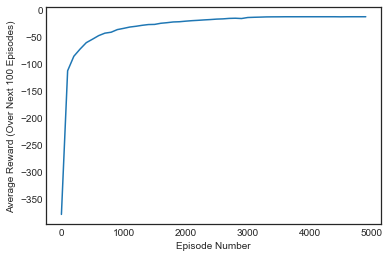

Best Average Reward over 100 Episodes: -13.0


In [12]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = td_control(env, num_episodes=5000, alpha=.01)

In [13]:
# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):


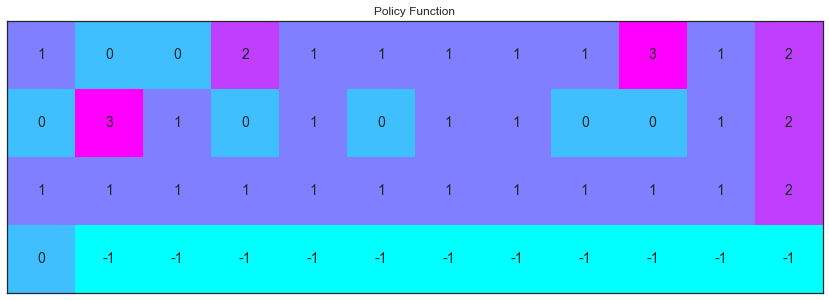

In [14]:
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
plot_values(np.reshape(policy_sarsa, (4,12)), name='Policy')

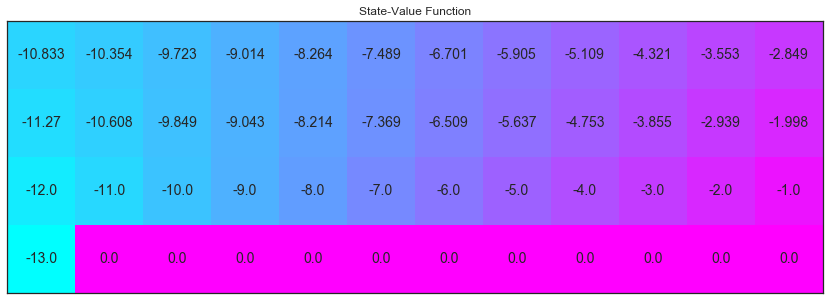

In [15]:
# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa, name='State-Value')

## Part 2: TD Control: Q-learning

In [16]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    current_value = Q[state][action] # estimate in Q-table for current state-action pair
    Qsa_next = np.max(Q[next_state]) if next_state is not None else 0 # value of next state by greedy action
    
    TD_target = reward + (gamma * Qsa_next) # construct TD target
    TD_error = TD_target - current_value # construct TD error
    new_value = current_value + (alpha * (TD_error)) # apply update rule
    return new_value

In [17]:
def td_control(env, num_episodes, alpha, gamma=1.0, plot_every=100):

    nA = env.action_space.n # number of actions
    Q = defaultdict(lambda: np.zeros(nA)) # initialize empty dictionary of arrays
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every) # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes) # average scores over every plot_every episodes
    
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        score = 0 # initialize score
        state = env.reset() # start episode
        
        epsilon = 1.0 / i_episode # set value of epsilon
        
        while True:
            action = get_epsilon_greedy(Q, state, nA, epsilon) # epsilon-greedy action selection
            next_state, reward, done, info = env.step(action) # take action A, observe R, S'
            score += reward # add reward to agent's score
            Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state)
            state = next_state
            
            if done:
                tmp_scores.append(score)
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0, num_episodes, len(avg_scores), endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel(f'Average Reward (Over Next {plot_every} Episodes)')
    plt.show()
    
    # print best 100-episode performance
    print((f'Best Average Reward over {plot_every} Episodes:'), np.max(avg_scores))
    return Q

Episode 5000/5000

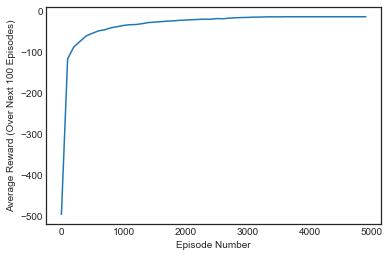

Best Average Reward over 100 Episodes: -13.0


In [18]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = td_control(env, num_episodes=5000, alpha=.01)

In [19]:
# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):


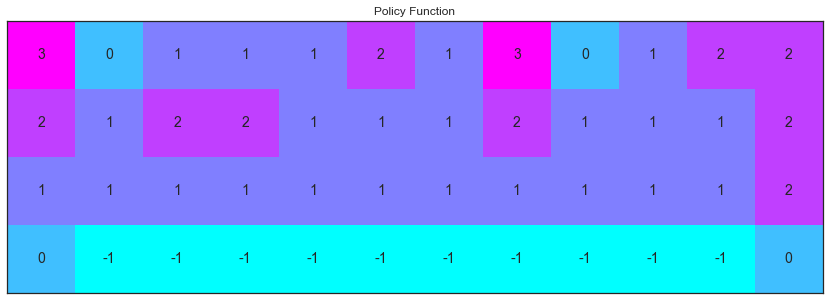

In [20]:
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
plot_values(np.reshape(policy_sarsamax, (4,12)), name='Policy')

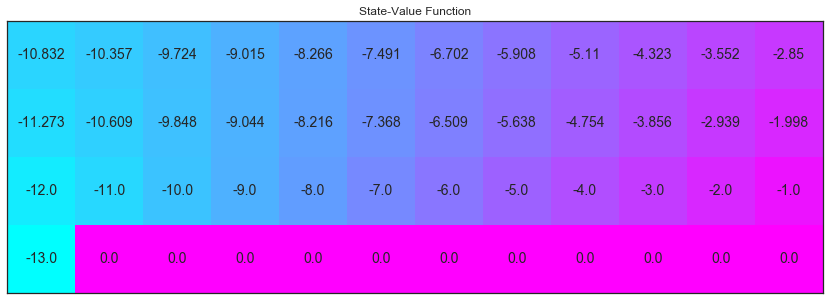

In [21]:
# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)], name='State-Value')

## Part 3: TD Control: Expected Sarsa

In [22]:
def update_Q_expected_sarsa(alpha, gamma, nA, epsilon, Q, state, action, reward, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    current_value = Q[state][action] # estimate in Q-table for current state-action pair
    policy_next_state = np.ones(nA) * epsilon / nA # current policy for next state S'
    policy_next_state[np.argmax(Q[next_state])] = 1 - epsilon + (epsilon / nA) # greedy action
    Qsa_next = np.dot(Q[next_state], policy_next_state) # get value of state at next time step
    
    TD_target = reward + (gamma * Qsa_next) # construct target
    TD_error = TD_target - current_value # construct TD error
    new_value = current_value + (alpha * (TD_error)) # apply update rule
    return new_value

In [23]:
def td_control(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    
    nA = env.action_space.n # number of actions
    Q = defaultdict(lambda: np.zeros(nA)) # initialize empty dictionary of arrays
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every) # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes) # average scores over every plot_every episodes
    
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        score = 0 # initialize score
        state = env.reset() # start episode
        
        epsilon = 5e-3 # set value of epsilon
        
        while True:
            action = get_epsilon_greedy(Q, state, nA, epsilon) # epsilon-greedy action selection
            next_state, reward, done, info = env.step(action) # take action A, observe R, S'
            score += reward # add reward to agent's score
            Q[state][action] = update_Q_expected_sarsa(alpha, gamma, nA, epsilon, Q, state, action, reward, next_state)
            state = next_state
            
            if done:
                tmp_scores.append(score)
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0, num_episodes, len(avg_scores), endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel(f'Average Reward (Over Next {plot_every} Episodes)')
    plt.show()
    
    # print best 100-episode performance
    print((f'Best Average Reward over {plot_every} Episodes:'), np.max(avg_scores))
    return Q

Episode 5000/5000

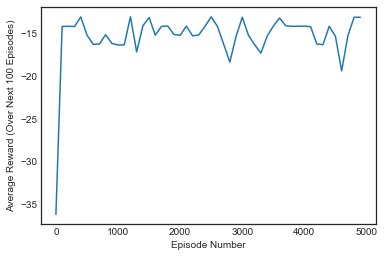

Best Average Reward over 100 Episodes: -13.02


In [24]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expected_sarsa = td_control(env, 5000, 1)

In [25]:
# print the estimated optimal policy
policy_expected_sarsa = np.array([np.argmax(Q_expected_sarsa[key]) if key in Q_expected_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expected_sarsa)

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):


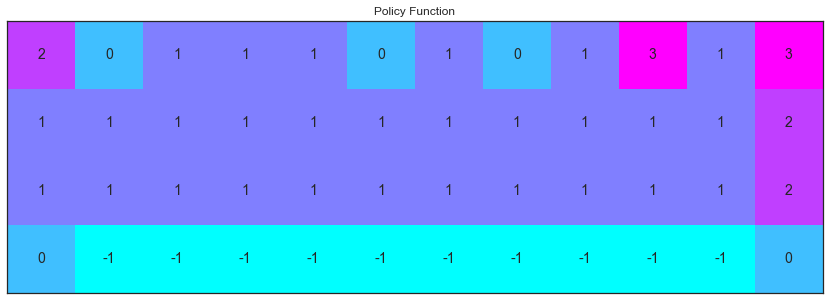

In [26]:
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
plot_values(np.reshape(policy_expected_sarsa, (4,12)), name='Policy')

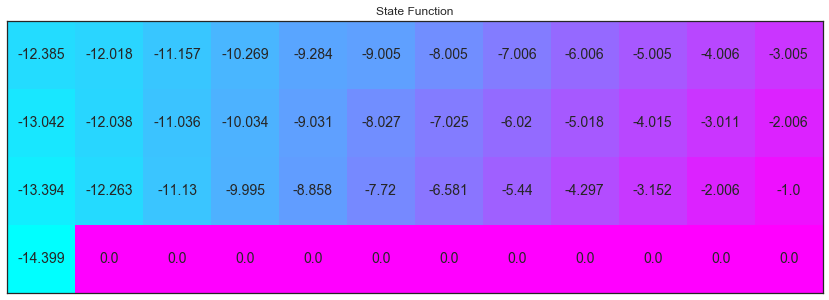

In [27]:
# plot the estimated optimal state-value function
plot_values([np.max(Q_expected_sarsa[key]) if key in Q_expected_sarsa else 0 for key in np.arange(48)])

---